In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

!pip install minisom
from minisom import MiniSom

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import plotly.express as px
from ipywidgets import interact

%matplotlib inline

In [2]:
def som_pie_grid(som, data, labels):
  """Helper to create piechart grid viz
  
  Example: https://raw.githubusercontent.com/JustGlowing/minisom/master/examples/resulting_images/som_iris_pies.png

  :param som: fitted MiniSom instance
  :param data: the data the MiniSom was fit to
  :param labels: an array of labels to use for coloring visual
  """
  labels_map = som.labels_map(data, labels)
  label_names = np.unique(labels)

  plt.figure(figsize=(70, 70))
  the_grid = GridSpec(70, 70)
  for position in labels_map.keys():
      label_fracs = [labels_map[position][lab] for lab in label_names]
      plt.subplot(the_grid[position[1] - 12, position[0]], aspect=1)
      patches, texts = plt.pie(label_fracs)

  plt.show()

  # Cheating way to align legend, create a separate figure just 
  # for legend.  Will have superfluous whitespace below
  plt.legend(patches, label_names, loc='upper left', ncol=5)
  plt.axis('off')
  plt.show()

* Read in the data from `data_url`
* Drop all NAs
* Filter based on the `'Pos'` column to where only have the positions `['C', 'PG', 'SG']` remain
* Drop all non-numeric columns
* Scale the data

In [3]:
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/nba_player_seasons.csv"

In [4]:
nba_df = pd.read_csv(data_url)
# nba_df.info()
# nba_df.head()

In [5]:
nba_df.isnull().sum()[lambda x:x>0]

FG%      10
3P%     174
2P%      31
eFG%     10
FT%     104
dtype: int64

In [6]:
nba_df.dropna(inplace=True)
nba_df.isnull().sum()[lambda x:x>0]

Series([], dtype: int64)

In [7]:
nba_df = nba_df.loc[nba_df['Pos'].isin(['C', 'PG', 'SG'])].reset_index(drop=True)

In [8]:
nba_num = nba_df.select_dtypes(include='number')

In [9]:
scale = StandardScaler()
nba_num_sca = scale.fit_transform(nba_num)

* Fit a `MiniSom` instance to the scaled data
  * Choose your own grid size
  * Set a `random_seed` to have reproducible results
  * Initialize the `MiniSom` weight vectors using `.pca_weights_init()` or `.random_weights_init()`
  * Train the model using `.train_random()` or `.train_batch()`

In [10]:
5*np.sqrt(nba_num_sca.shape[0])

169.8528775146303

In [11]:
grid_cols = 18
grid_rows = 10
n_cols = nba_num.shape[1]

In [12]:
som = MiniSom(grid_cols, grid_rows, n_cols)
som.pca_weights_init(nba_num_sca)
som.train_random(nba_num_sca, num_iteration=1000)

In [13]:
weights = som.get_weights()

In [14]:
x_winners = []
y_winners = []
winner_ids = []

for row in range(len(nba_num_sca)):
  winner_x, winner_y = som.winner(nba_num_sca[row])
  x_winners.append(winner_x)
  y_winners.append(winner_y)
  winner_ids.append((winner_x, winner_y))

winner_df = pd.DataFrame({'winner_x': x_winners, 'winner_y':y_winners, 'winner_id':winner_ids})

In [15]:
winner_df['pos'] = nba_df['Pos']

In [16]:
winner_df

,winner_x,winner_y,winner_id,pos
0,11,2,"(11, 2)",SG
1,9,1,"(9, 1)",PG
2,3,9,"(3, 9)",C
3,3,7,"(3, 7)",C
4,6,0,"(6, 0)",SG
...,...,...,...,...
1149,17,0,"(17, 0)",PG
1150,5,0,"(5, 0)",SG
1151,5,2,"(5, 2)",PG
1152,10,2,"(10, 2)",SG


* Use the helper function defined at the top of the notebook to plot the SOM's fit
  * Use the players' positions (the `'Pos'` column) as the labels in the viz
  * Experiment with the SOM's grid size, initialization method, and training method.  Decide a 'good' fit using this visual as guidance.

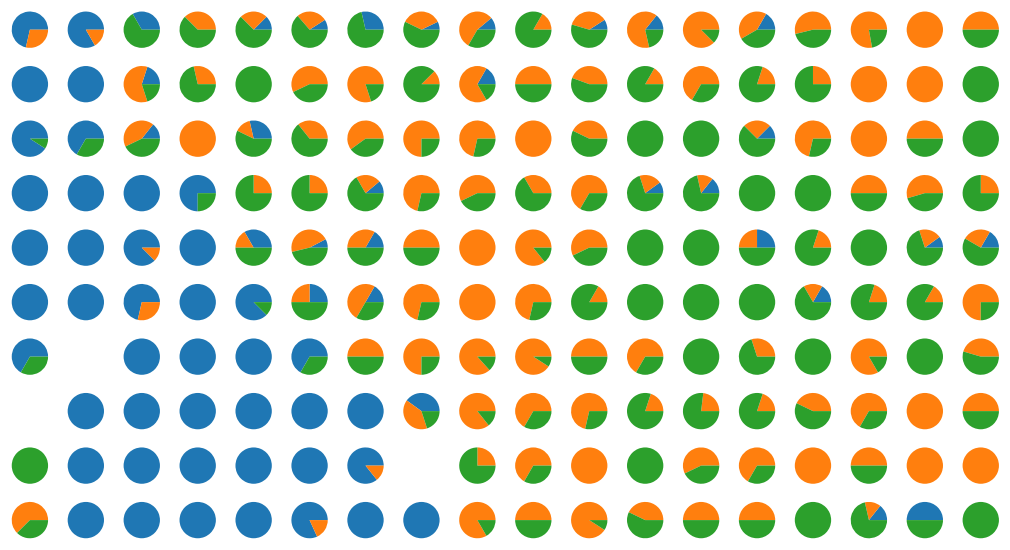

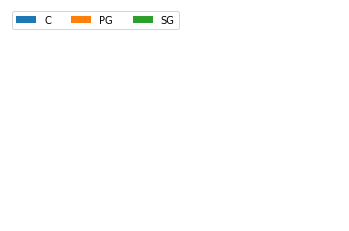

In [17]:
som_pie_grid(som, nba_num_sca, nba_df['Pos'])

* Perform dimension reduction (to 2d) with another method (perhaps `PCA` or `TSNE`).
* Create a scatter plot of the results of this dimension reduction and color the scatter plot by the players' positions (the `'Pos'` column).
  * How do these results compare to that of the SOM? What are the pros and cons of the different approaches you took in this notebook?

In [18]:
pca = PCA(n_components=2)
nba_pca = pd.DataFrame(pca.fit_transform(nba_num_sca))
nba_pca['Pos'] = nba_df['Pos']

px.scatter(data_frame=nba_pca, x=0, y=1, color='Pos')

In [20]:
@interact(perplexity=range(5,50,5))
def tsne_scatter(perplexity):
  tsne = TSNE(n_components=2, perplexity=perplexity)
  nba_tsne = pd.DataFrame(tsne.fit_transform(nba_num_sca))
  nba_tsne['Pos'] = nba_df['Pos']

  fig = px.scatter(data_frame=nba_tsne, x=0, y=1, color='Pos')
  fig.update_traces(marker_line_color='black', marker_line_width=1)
  fig.show()

interactive(children=(Dropdown(description='perplexity', options=(5, 10, 15, 20, 25, 30, 35, 40, 45), value=5)…